# Sunlight Regressor
回歸器去預測光照度，而不是發電量

在原本的資料檔中寫入新的一欄 “Sunlight_pred”

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

## Params

In [19]:
DATA_PATH = 'big_one_data.csv'
EPOCHS = 5
# COLUMNS = ['Sunlight(Lux)', 'WindSpeed(m/s)', 'height', 'angle', 'LocationCode']

## Dataloader

In [55]:
TARGET_COL = 'Power'
OUT_COL = ['DateTime', 'Sunlight', 'sum_ele', 'sum_pos', 'high' , 'ele']

class FeatDataloader(Dataset):
    def __init__(self, filename, test_size=0.2, random_state=42):
        self.data = pd.read_csv(filename)

        # 「真」資料：完整無缺值者
        self.truth_data = self.data[pd.notna(self.data[TARGET_COL])].drop(columns=OUT_COL).reset_index(drop=True).astype(float)
        self.truth_data = self.truth_data[(self.truth_data['Hour'] > 7) & (self.truth_data['Hour'] < 17)]

        self.predict_data = self.data[pd.isna(self.data[TARGET_COL])].reset_index(drop=True).drop(columns=[TARGET_COL])
        self.predict_data = self.predict_data.drop(columns=OUT_COL)
        
        # 只有不是最大值的資料會用來訓練與測試
        self.train_data, self.test_data = train_test_split(self.truth_data, test_size=test_size, random_state=random_state)
        
        # 訓練集
        self.train_data = self.train_data.dropna()
        self.X_train = self.train_data.drop(columns=TARGET_COL).values
        self.y_train = self.train_data[TARGET_COL].values

        # 測試集
        self.test_data = self.test_data.dropna()
        self.X_test = self.test_data.drop(columns=TARGET_COL).values
        self.y_test = self.test_data[TARGET_COL].values

                
    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        X = self.X_train[idx]
        y = self.y_train[idx]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

## 個別訓練
每個檔案訓練一個模型

In [56]:
avg_mae_list = []
avg_mse_list = []
all_true = []
all_pred = []


dataset = FeatDataloader(DATA_PATH)

train_loader = DataLoader(
    TensorDataset(
        torch.tensor(dataset.X_train, dtype=torch.float32),
        torch.tensor(dataset.y_train, dtype=torch.float32),
    ),
    batch_size=32,
    shuffle=True,
)

test_loader = DataLoader(
    TensorDataset(
        torch.tensor(dataset.X_test, dtype=torch.float32),
        torch.tensor(dataset.y_test, dtype=torch.float32),
    ),
    batch_size=32,
    shuffle=False,
)

# reg = RandomForestRegressor(n_estimators=100, random_state=42)
# reg.fit(dataset.X_train, dataset.y_train)
reg = XGBRegressor(n_estimators=100, random_state=42)
#reg = LinearRegression()
reg.fit(dataset.X_train, dataset.y_train)
predictions = reg.predict(dataset.X_test)


mse_list = []
mae_list = []

# 分 batch 測試
for batch_X, batch_y in test_loader:
    predictions = reg.predict(batch_X)
    mse = mean_squared_error(batch_y, predictions)
    mse_list.append(mse)

    mae = mean_absolute_error(batch_y, predictions)
    mae_list.append(mae)

    all_true.extend(batch_y.numpy())
    all_pred.extend(predictions)

avg_mae = np.average(mae_list)
avg_mse = np.average(mse_list)
avg_mse_list.append(avg_mse)
avg_mae_list.append(avg_mae)

print(f"Processing file: {DATA_PATH}, MAE: {avg_mae}, MSE: {avg_mse}")

# 填值
df = dataset.data
if not dataset.predict_data.empty:
    X_predict = dataset.predict_data.values
    predicted_values = reg.predict(X_predict)
    #print(dataset.predict_data.values[0], predicted_values[0])
    
    # 將預測結果寫回 predict_data 的目標列
    dataset.predict_data[TARGET_COL] = predicted_values

    # 找出 predict_data 在原始數據中的索引
    predict_indices = dataset.data[pd.isna(dataset.data[TARGET_COL])].index

    # 將預測結果更新回原始數據框
    df.loc[predict_indices, TARGET_COL] = predicted_values

    #output_filepath = os.path.join('../combine_data/FinalData-v2', filename) 
    df.to_csv('my_ans_tab_lr.csv', index=False)
    #print(f"Updated data saved to {output_filepath}")

Processing file: big_one_data.csv, MAE: 34.75523376464844, MSE: 5621.25


### Visualization
MSE/MAE

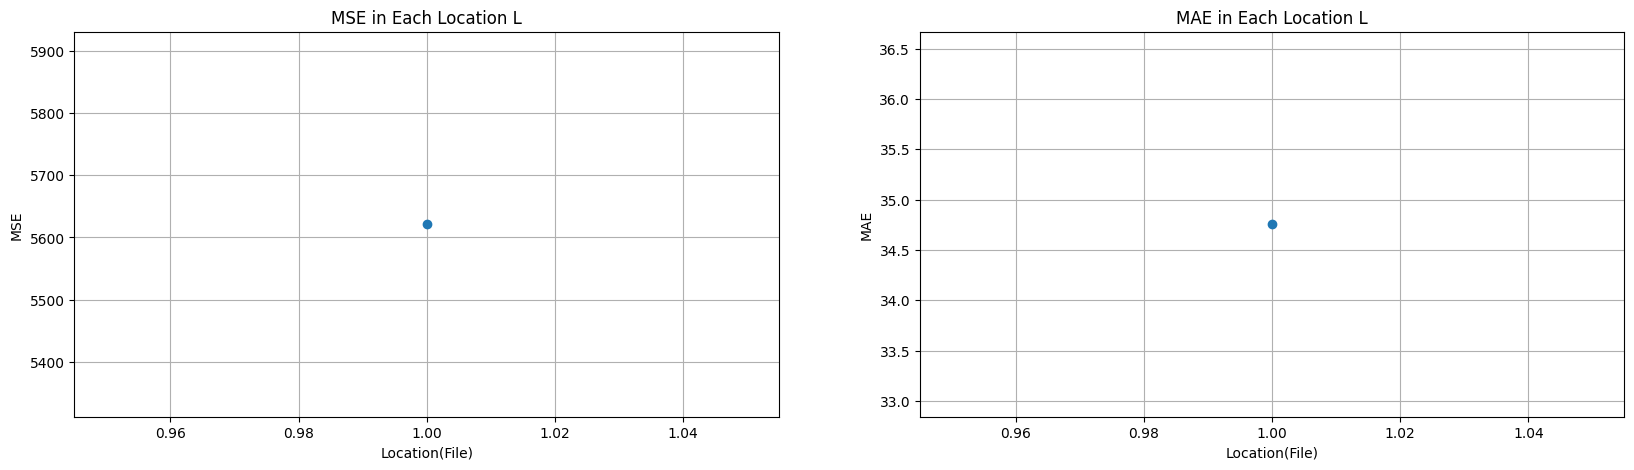

Average MSE:5621.25
Average MAE:34.75523376464844


In [57]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(range(1, len(avg_mse_list) + 1), avg_mse_list, marker='o', linestyle='-')
plt.title("MSE in Each Location L")
plt.xlabel("Location(File)")
plt.ylabel("MSE")
plt.grid()

plt.subplot(122)
plt.plot(range(1, len(avg_mae_list) + 1), avg_mae_list, marker='o', linestyle='-')
plt.title("MAE in Each Location L")
plt.xlabel("Location(File)")
plt.ylabel("MAE")
plt.grid()
plt.show()

plt.show()

avg_mse = np.average(mse_list)
avg_mae = np.average(mae_list)
print(f"Average MSE:{avg_mse}\nAverage MAE:{avg_mae}")

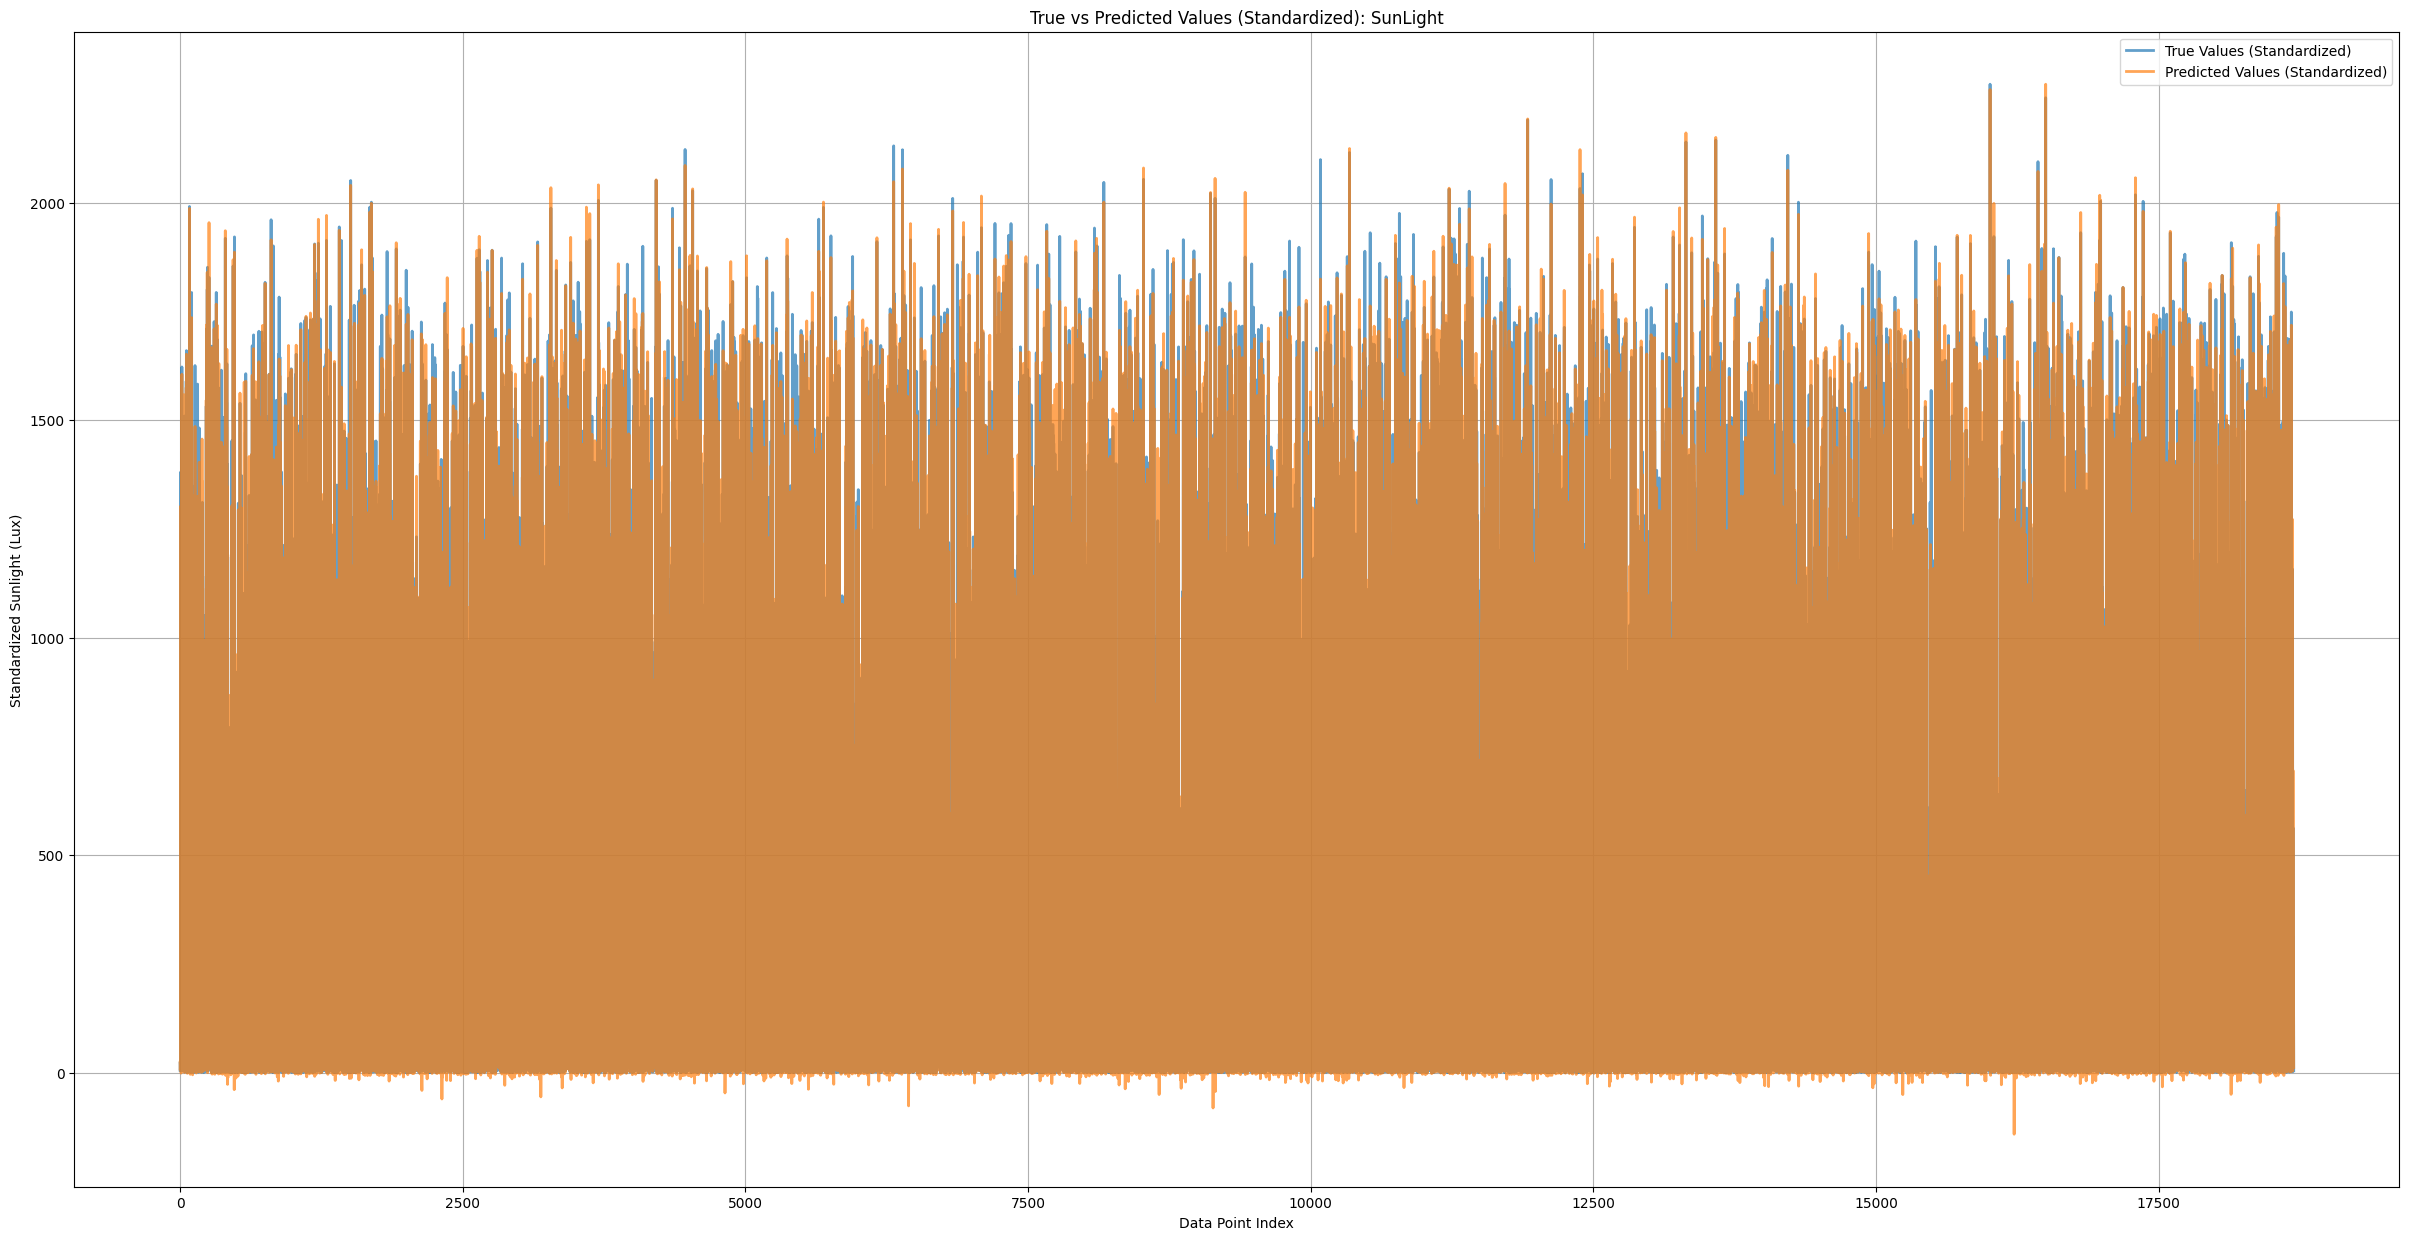

In [58]:
scaler = StandardScaler()

all_true = np.array(all_true).reshape(-1, 1)
all_pred = np.array(all_pred).reshape(-1, 1)

#all_true_scaled = scaler.fit_transform(all_true)
#all_pred_scaled = scaler.transform(all_pred)

# 绘图
plt.figure(figsize=(30, 15))
plt.plot(all_true, label="True Values (Standardized)", linestyle='-', alpha=0.7, linewidth=2)
plt.plot(all_pred, label="Predicted Values (Standardized)", linestyle='-', alpha=0.7, linewidth=2)
plt.title("True vs Predicted Values (Standardized): SunLight")
plt.xlabel("Data Point Index")
plt.ylabel("Standardized Sunlight (Lux)")
plt.legend()
plt.grid()
plt.show()

## 全部（不採用）
全部資料拿來訓練

In [ ]:
# 存放所有的數據
all_X_train, all_y_train = [], []
all_X_test, all_y_test = [], []


# 讀取並合併數據
for filename in os.listdir(DATA_PATH):
    print(f"Loading data from file: {filename}")
    
    # 載入資料
    filepath = os.path.join(DATA_PATH, filename)
    dataset = LightDataloader(filepath)
    
    # 合併訓練集與測試集
    all_X_train.append(dataset.X_train)
    all_y_train.append(dataset.y_train)
    all_X_test.append(dataset.X_test)
    all_y_test.append(dataset.y_test)

# 將數據拼接到一個大數據集
X_train = np.vstack(all_X_train)
y_train = np.hstack(all_y_train)
X_test = np.vstack(all_X_test)
y_test = np.hstack(all_y_test)

# 建立 DataLoader
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    ),
    batch_size=32,
    shuffle=True,
)

test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    ),
    batch_size=32,
    shuffle=False,
)

# 訓練模型
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

# 預測與評估
mse_list = []
mae_list = []
all_true = []
all_pred = []

for batch_X, batch_y in test_loader:
    predictions = reg.predict(batch_X)
    mse = mean_squared_error(batch_y, predictions)
    mse_list.append(mse)

    mae = mean_absolute_error(batch_y, predictions)
    mae_list.append(mae)

    all_true.extend(batch_y.numpy())
    all_pred.extend(predictions)

# 輸出結果
print(f"Overall MSE: {np.mean(mse_list)}")
print(f"Overall MAE: {np.mean(mae_list)}")

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(range(1, len(mse_list) + 1), mse_list, marker='o', linestyle='-')
plt.title("MSE Over Test Batches")
plt.xlabel("Batch Number")
plt.ylabel("MSE")
plt.grid()

plt.subplot(122)
plt.plot(range(1, len(mae_list) + 1), mae_list, marker='o', linestyle='-')
plt.title("MAE Over Test Batches")
plt.xlabel("Batch Number")
plt.ylabel("MAE")
plt.grid()
plt.show()

plt.show()

avg_mse = np.average(mse_list)
avg_mae = np.average(mae_list)
print(f"Average MSE:{avg_mse}\nAverage MAE:{avg_mae}")